# Import package and make test environment

In [9]:
import time
import gym
from gym import envs
from gym import wrappers, logger
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from pathlib import Path, PureWindowsPath
import torch
from agent.ddpgagent import Agent3
from agent.ppoagent import PPO
from agent.dqnagent import Agent
from utility import get_unique_numbers, score_save, count_impulses, count_edgezone
import math
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load_tracks_from=TRACK -- Load a specific map from a pkl file
# Make environment
TRACK = 'track'
env = gym.make('CarRacing-v0', num_obstacles=100, show_info_panel=1,
               num_tracks=1, num_lanes=1, discretize_actions='soft',
               allow_outside=False, 
               grayscale=1, frames_per_state=1,
               load_tracks_from = TRACK)
observation_space = env.observation_space.shape
action_space = env.action_space.n
print('State shape: ', observation_space)
print('Number of actions: ', action_space)

State shape:  (96, 96)
Number of actions:  5


# Parameter load and create agent
## Create storage folder

In [10]:
from utility import Config_DQN
from utility import Config_DDPG
from utility import Config_PPO

Episode = 1000         # test episode
total_test_episodes = Episode
Time_stamp = 1500   # time stamp -- simply initial parameters, no use in the test

cfg_dqn = Config_DQN(print_ep=1, freq_save_epi=10, n_episodes=10, GAMMA=0.95, SEED=32, eps_end=0.001, max_t=1200)
setattr(cfg_dqn, 'state_size', observation_space)
setattr(cfg_dqn, 'action_size', action_space) 

cfg_ppo = Config_PPO(max_training_timesteps=int(900000),max_ep_len=Time_stamp,K_epochs=30, save_model_freq=500,eps_clip=0.2,gamma=0.95)
setattr(cfg_ppo, 'state_dim', env.observation_space.shape)
setattr(cfg_ppo, 'action_dim', env.action_space.n)

print('Max training time steps: {}\t \n State dimension: {}\t \n Action size: {}\t'.format(cfg_ppo.max_training_timesteps,cfg_ppo.state_dim,cfg_ppo.action_dim))
print("K-epocs:{}\n max timesteps in one episode: {} \n Expected episode: {}\n".format(cfg_ppo.K_epochs,cfg_ppo.max_ep_len,(cfg_ppo.max_training_timesteps // cfg_ppo.max_ep_len)*2))

cfg_ddpg = Config_DDPG(Episode=int(Episode), max_ep_len=Time_stamp,random_seed=int(32),freq_save_epi=int(5))
setattr(cfg_ddpg, 'state_size', observation_space)  # create the state size parameter
setattr(cfg_ddpg, 'action_size', action_space)      # create the action size parameter


# Create agent
agent_DQN = Agent(cfg_dqn)
agent_DDPG = Agent3(cfg_ddpg)
agent_PPO = PPO(cfg_ppo)

# create folder for the test data
file_name = 'Test_Default_Nearness'
p_model = (Path()/ 'document'/'Test'/file_name)
p_model.mkdir(parents=True, exist_ok=True)



Max training time steps: 900000	 
 State dimension: (96, 96)	 
 Action size: 5	
K-epocs:30
 max timesteps in one episode: 1500 
 Expected episode: 1200



# Load agent and folder

## Model folders
### Model folder
Due to variation of environment setting, please notice the printing result of:
```python
print(f"DQN folders:{DQN_folders}\n")
print(f"DDPG folders:{DDPG_folders}\n")
print(f"PPO folders:{PPO_folders}\n")
```

The command lines print out the walking files of trained model's directory.

### config folder
Each folder(DQN, DDPG, PPO) storages the trained model with different reward configurations.

```python
print(f"DQN model files {list(DQN_folders[0].rglob('*.pth'))}")
```
This commandline prints out the walking files under the route.


In [11]:
from pathlib import Path
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import math
# All folders
Experiment = (Path() / 'Model')
directory = os.walk(Experiment)
# filter out the touching the near zoen whenever the car is about to tune angle.
gap_threshold = 35
folder_list = [x for x in Experiment.iterdir() if x.is_dir()]
print(f"Folder list in Experiment:{folder_list}\n")

# all sub folders
DQN_folders = [a for a in folder_list[1].iterdir() if a.is_dir()]
DDPG_folders = [b for b in folder_list[0].iterdir() if b.is_dir()]
PPO_folders = [c for c in folder_list[2].iterdir() if c.is_dir()]

# default
print(f"DQN folders:{DQN_folders}\n")
print(f"DDPG folders:{DDPG_folders}\n")
print(f"PPO folders:{PPO_folders}\n")
print(f"------------------------------------\n")
print(f"DQN model files {list(DQN_folders[0].rglob('*.pth'))}")
print(f"DDPG model files {list(DDPG_folders[0].rglob('*.pth'))}")
print(f"PPO model files {list(PPO_folders[0].rglob('*.pth'))}")


Folder list in Experiment:[PosixPath('Model/DDPG'), PosixPath('Model/DQN'), PosixPath('Model/PPO')]

DQN folders:[PosixPath('Model/DQN/DQN_reward_reshape'), PosixPath('Model/DQN/DQN_reward_default')]

DDPG folders:[PosixPath('Model/DDPG/DDPG_reshape_timeout'), PosixPath('Model/DDPG/DDPG_default')]

PPO folders:[PosixPath('Model/PPO/PPO_reward_deafult'), PosixPath('Model/PPO/PPO_reshape_timeout')]

------------------------------------

DQN model files [PosixPath('Model/DQN/DQN_reward_reshape/DQN_local1000.pth'), PosixPath('Model/DQN/DQN_reward_reshape/DQN_local500.pth')]
DDPG model files [PosixPath('Model/DDPG/DDPG_reshape_timeout/DDPG_actor500.pth'), PosixPath('Model/DDPG/DDPG_reshape_timeout/DDPG_actor1000.pth'), PosixPath('Model/DDPG/DDPG_reshape_timeout/DDPG_critic1000.pth'), PosixPath('Model/DDPG/DDPG_reshape_timeout/DDPG_critic500.pth')]
PPO model files [PosixPath('Model/PPO/PPO_reward_deafult/PPO_adreward_500.pth'), PosixPath('Model/PPO/PPO_reward_deafult/PPO_adreward_1000.pth'),

## Load Default model

Find the default folder and load the trained model.
> Hint: modify the number inside the braket: `DQN_folders[0]` (the Win-based pc might be the `0`, but might be varied due to basic setting.)

In [12]:
# Default
Default_DQN_model_path = DQN_folders[1]
Default_DDPG_model_path =DDPG_folders[1]
Default_PPO_model_path = PPO_folders[0]

device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # device check for GPU avaialbility

# Default Agent
DQN_model_name = f"DQN_local{1000}.pth"
agent_DQN.qnetwork_local.load_state_dict(torch.load((Default_DQN_model_path/DQN_model_name),map_location=torch.device(device)))

actor_name = f'DDPG_actor{1000}.pth'
critic_name = f'DDPG_critic{1000}.pth'
agent_DDPG.actor_local.load_state_dict(torch.load((Default_DDPG_model_path/actor_name),map_location=torch.device(device)))
agent_DDPG.critic_local.load_state_dict(torch.load((Default_DDPG_model_path/critic_name),map_location=torch.device(device)))
PPOmodel_name = f"PPO_adreward_{1374}.pth"
agent_PPO.load((Default_PPO_model_path / PPOmodel_name))



## reward reshape agent
The opration is similar to [previous section](#load-default-model).

Command loading reward reshape part if tested default agents.


In [13]:
# check folder
print(f"DQN folders:{DQN_folders}\n")
print(f"DDPG folders:{DDPG_folders}\n")
print(f"PPO folders:{PPO_folders}\n")

DQN folders:[PosixPath('Model/DQN/DQN_reward_reshape'), PosixPath('Model/DQN/DQN_reward_default')]

DDPG folders:[PosixPath('Model/DDPG/DDPG_reshape_timeout'), PosixPath('Model/DDPG/DDPG_default')]

PPO folders:[PosixPath('Model/PPO/PPO_reward_deafult'), PosixPath('Model/PPO/PPO_reshape_timeout')]



In [14]:

# # # Reshape
# R_DQN_model_path = DQN_folders[1]
# R_DDPG_model_path = DDPG_folders[2] # :[WindowsPath('Experiment/DDPG/DDPG_default'), WindowsPath('Experiment/DDPG/DDPG_reshape'), WindowsPath('Experiment/DDPG/DDPG_reshape_timeout')]
# R_PPO_model_path = PPO_folders[1]

# device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # device check for GPU avaialbility

# # Reshape Agent
# DQN_model_name = f"DQN_local{1000}.pth"
# agent_DQN.qnetwork_local.load_state_dict(torch.load((R_DQN_model_path/DQN_model_name),map_location=torch.device('cuda')))

# actor_name = f'DDPG_actor{1000}.pth'
# critic_name = f'DDPG_critic{1000}.pth'
# agent_DDPG.actor_local.load_state_dict(torch.load((R_DDPG_model_path/actor_name),map_location=torch.device('cuda')))
# agent_DDPG.critic_local.load_state_dict(torch.load((R_DDPG_model_path/critic_name),map_location=torch.device('cuda')))
# PPOmodel_name = f"PPO_adreward_{1018}.pth"
# agent_PPO.load((R_PPO_model_path / PPOmodel_name))



# Test Start

## Set up test episodes - How many testing episodes?

## DDPG agent

# Total test episode

In [15]:
# total_test_episodes = 3

Episode: 1 		 Reward: -85.19999999999997
Episode: 2 		 Reward: -23.624999999998984
Total test time: 00:00:07.67


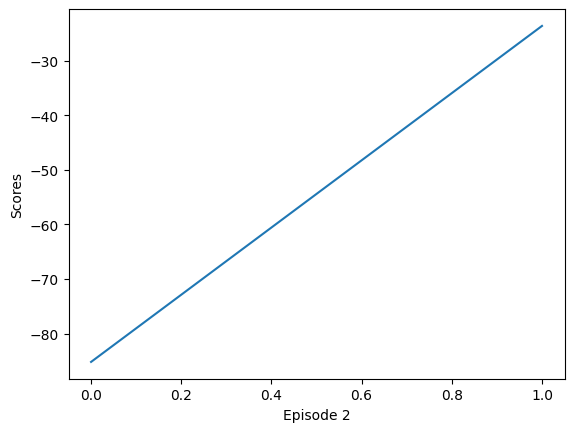

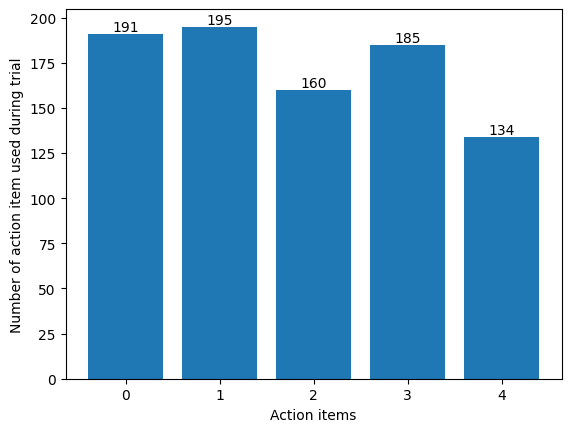

In [16]:
from collections import deque
import numpy as np
from utility import get_unique_numbers, count_edgezone
import time
# DDPG

test_running_reward = 0 # reset calculation reward

ac =[]
start = time.time()
runn_ep =[]
scores =[]
scores_deque = deque(maxlen=100)
avg_scores =[]
Bmp = []
T_Bmp = []
bumps = 0
if p_model.is_dir():
    nb_name = 'DDPG_Test_log.txt'
with open(p_model.joinpath(nb_name), "w") as f:

    for ep in range(1, total_test_episodes+1):
        
        start_ep = time.time()
        ep_reward = 0
        runn_ep.append(ep)
        state = env.reset()
        Ep_bmp = []
        for t in range(1, 1500):
            # bumps = 0
            action = agent_DDPG.act(state)
            ac.append(action)
            state, reward, done, bumps = env.step(action) # reward return

            Ep_bmp.append(bumps)
            T_Bmp.append(bumps)
            ep_reward += reward
            # env.render('rgb_array') # uncommand to display -- warning: expensive resources.

            if done:
                break
        Bmp.append(Ep_bmp)
        scores_deque.append(ep_reward)
        avg_scores.append(np.mean(scores_deque))
        end_ep = time.time()
        hours_ep, rem_ep = divmod(end_ep-start_ep, 3600)
        minutes_ep, seconds_ep = divmod(rem_ep, 60)
        

        f.write("Episode{} (survive time): {:0>2}:{:0>2}:{:05.2f}\n".format(ep,int(hours_ep),int(minutes_ep),seconds_ep))
        test_running_reward +=  ep_reward

        # print('Episode: {} \t\t Reward: {}'.format(ep, round(ep_reward, 2)))
        print('Episode: {} \t\t Reward: {}'.format(ep, avg_scores[ep-1]))

        scores.append(round(ep_reward, 2))
        ep_reward = 0
    env.close()

    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Total test time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    
    # count the bump instances.
    count_list_DDPG = []
    for i in range(len(Bmp)):
        count_list_DDPG.append(count_impulses(Bmp[i]))
    data_ddpg = {'Bump_instance': count_list_DDPG}
    Bump_track = pd.DataFrame(data_ddpg)
    Tcount_DDPG = count_edgezone(T_Bmp,gap_threshold )
    
    f.write("Total Test time (survive time): {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours),int(minutes),seconds))
    f.write('Toal epoch:%s\n'%total_test_episodes)
    f.write("Bump instances of total: %s\n"%Tcount_DDPG)
    f.write("Bump to edge zone %s\n"%count_edgezone(T_Bmp, gap_threshold))
    f.close()


DDPG_avg = avg_scores
DDPG_scores = scores
DDPG_ac = ac

# save csv file
csv_name = f"DDPG_default"
score_save(scores,avg_scores,file_name=csv_name,path=p_model,print_=False) # save score table as csv file
count_impulse_file = f"DDPG_default_count"
Bump_track.to_csv((p_model/f"{count_impulse_file}.csv")) # save bump instances as csv file


# # plot the bump instances.
# for i in range(total_test_episodes):
#     plt.subplot(1, total_test_episodes, i+1)
#     plt.plot(Bmp[i])
#     plt.title(f'Ct_:{data["Bump_instance"][i]}')

# plot for touch instanaces for the track.
# fig = plt.figure()
# plt.plot(T_Bmp)
# plt.title(f'Total bump instances:{Tcount_DDPG}')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(avg_scores)
# plt.plot(df['Averagescores'])
plt.ylabel('Scores')
plt.xlabel(f'Episode {len(avg_scores)}')
plt.show()

import matplotlib.pyplot as plt
import pandas as pd

action_list = [0,1,2,3,4]
h=[]
for i in action_list:
    h.append(ac.count(i))
bar_contain = plt.bar(action_list,h)
plt.xlabel('Action items')
plt.ylabel('Number of action item used during trial')
plt.bar_label(bar_contain)
plt.show()




## PPO agent test

Episode: 1 		 Reward: -594.6500000000001
Episode: 2 		 Reward: -578.2250000000001
Episode: 3 		 Reward: -375.31666666666615
Total test time: 00:00:07.10


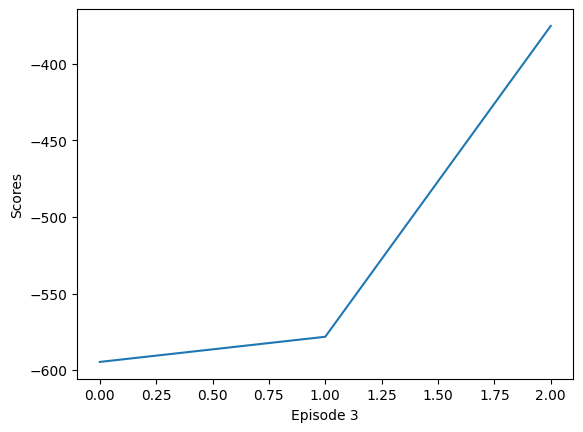

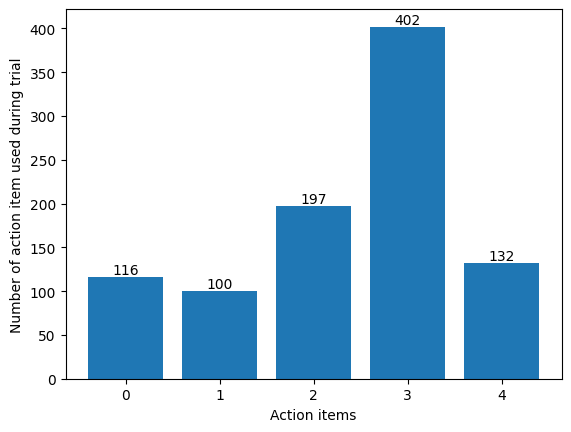

In [17]:
from collections import deque
import numpy as np
from utility import get_unique_numbers
import time

test_running_reward = 0
total_test_episodes = 3
ac =[]
start = time.time()
runn_ep =[]
scores =[]
scores_deque = deque(maxlen=100)
avg_scores =[]
Bmp =[]
T_Bmp = []
if p_model.is_dir():
    nb_name = 'PPO_Test_log.txt'
with open(p_model.joinpath(nb_name), "w") as f:

    for ep in range(1, total_test_episodes+1):
        start_ep = time.time()
        ep_reward = 0
        runn_ep.append(ep)
        state = env.reset()
        Ep_bump =[]
        for t in range(1, 1500):
            action = agent_PPO.select_action(state)
            ac.append(action)
            state, reward, done, bumps = env.step(action)
            Ep_bump.append(bumps)
            T_Bmp.append(bumps)
            ep_reward += reward
            # env.render('rgb_array') # uncommand to display -- warning: expensive resources.
            if done:
                break
        Bmp.append(Ep_bump)
        scores_deque.append(ep_reward)
        avg_scores.append(np.mean(scores_deque))
        end_ep = time.time()
        hours_ep, rem_ep = divmod(end_ep-start_ep, 3600)
        minutes_ep, seconds_ep = divmod(rem_ep, 60)

        f.write("Episode{} (survive time): {:0>2}:{:0>2}:{:05.2f}\n".format(ep,int(hours_ep),int(minutes_ep),seconds_ep))
        test_running_reward +=  ep_reward

        # print('Episode: {} \t\t Reward: {}'.format(ep, round(ep_reward, 2)))
        print('Episode: {} \t\t Reward: {}'.format(ep, avg_scores[ep-1]))

        scores.append(round(ep_reward, 2))
        ep_reward = 0
    env.close()

    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Total test time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    
    # count the bump instances.
    count_list_PPO = []
    for i in range(len(Bmp)):
        count_list_PPO.append(count_impulses(Bmp[i]))
    data_PPO = {'Bump_instance': count_list_PPO}
    Bump_track = pd.DataFrame(data_PPO)
    Tcount_PPO = count_edgezone(T_Bmp,gap_threshold)


    f.write("Total Test time (survive time): {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours),int(minutes),seconds))
    f.write('Toal epoch:%s\n'%total_test_episodes)
    f.write("Bump instances of total: %s\n"%Tcount_PPO)
    f.write("Bump to edge zone %s\n"%count_edgezone(T_Bmp, gap_threshold))
    f.close()

PPO_avg = avg_scores
PPO_scores = scores
PPO_ac = ac

csv_name = f"PPO_reshape"
score_save(scores,avg_scores,file_name=csv_name,path=p_model,print_=False) # save score table as csv file
count_impulse_file = f"PPO_default_count"
Bump_track.to_csv((p_model/f"{count_impulse_file}.csv")) # save bump instances as csv file

# count the bump instances.
count_list_PPO = []
for i in range(len(Bmp)):
    count_list_PPO.append(count_impulses(Bmp[i]))
data_PPO = {'Bump_instance': count_list_PPO}
Bump_track_PPO = pd.DataFrame(data_PPO)

# fig = plt.figure()
# plt.plot(T_Bmp)
# plt.title(f'Total bump instances:{count_impulses(T_Bmp)}')

# # plot the bump instances.
# for i in range(5):
#     plt.subplot(2, 5, i+1)
#     plt.plot(Bmp[i])
#     plt.title(f'Ct_:{count_list[i]}')
#     plt.subplot(2, 5, i+6)
#     plt.plot(Bmp[i+5])
#     plt.title(f'Ct_:{count_list[i+5]}')

# fig = plt.figure()
# plt.plot(T_Bmp)
# plt.title(f'Total bump instances:{Tcount_PPO}')


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(avg_scores)
# plt.plot(df['Averagescores'])
plt.ylabel('Scores')
plt.xlabel(f'Episode {len(avg_scores)}')
plt.show()

import matplotlib.pyplot as plt
import pandas as pd

action_list = [0,1,2,3,4]
h=[]
for i in action_list:
    h.append(ac.count(i))
bar_contain = plt.bar(action_list,h)
plt.xlabel('Action items')
plt.ylabel('Number of action item used during trial')
plt.bar_label(bar_contain)
plt.show()

## DQN agent test

Episode: 1 		 Reward: -27.850000000000122
Episode: 2 		 Reward: -27.850000000000122
Episode: 3 		 Reward: -27.850000000000122
Total test time: 00:00:09.42


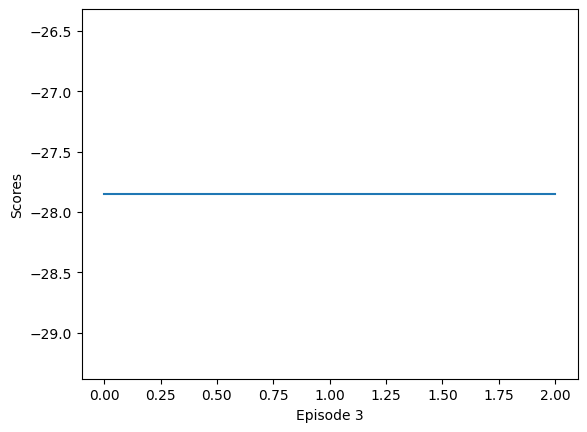

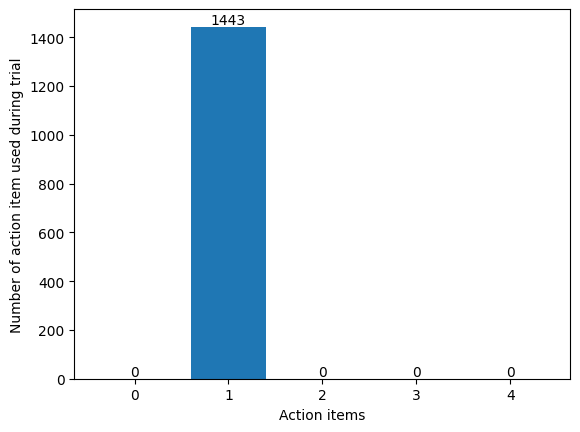

In [18]:
from collections import deque
import numpy as np
from utility import get_unique_numbers
import time

test_running_reward = 0

ac =[]
start = time.time()
runn_ep =[]
scores =[]
scores_deque = deque(maxlen=100)
avg_scores =[]
Bmp = []
T_Bmp = []
bumps = 0

if p_model.is_dir():
    nb_name = 'DQN_Test_log.txt'
with open(p_model.joinpath(nb_name), "w") as f:

    for ep in range(1, total_test_episodes+1):
        start_ep = time.time()
        ep_reward = 0
        runn_ep.append(ep)
        state = env.reset()
        Ep_bmp = []

        for t in range(1, 1500):
            action = agent_DQN.act(state)
            ac.append(action)
            state, reward, done, bumps = env.step(action)

            Ep_bmp.append(bumps)
            T_Bmp.append(bumps)
            ep_reward += reward
            # env.render('rgb_array') # uncommand to display -- warning: expensive resources.
            if done:
                break
        
        Bmp.append(Ep_bmp)
        scores_deque.append(ep_reward)
        avg_scores.append(np.mean(scores_deque))
        end_ep = time.time()
        hours_ep, rem_ep = divmod(end_ep-start_ep, 3600)
        minutes_ep, seconds_ep = divmod(rem_ep, 60)

        f.write("Episode{} (survive time): {:0>2}:{:0>2}:{:05.2f}\n".format(ep,int(hours_ep),int(minutes_ep),seconds_ep))
        test_running_reward +=  ep_reward

        print('Episode: {} \t\t Reward: {}'.format(ep, avg_scores[ep-1]))

        scores.append(round(ep_reward, 2))
        ep_reward = 0
    env.close()

    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Total test time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    
    # count the bump instances.
    count_list_DQN = []
    for i in range(len(Bmp)):
        count_list_DQN.append(count_impulses(Bmp[i]))
    data_dqn = {'Bump_instance': count_list_DQN}
    Bump_track = pd.DataFrame(data_dqn)
    Tcount_DQN = count_edgezone(T_Bmp,gap_threshold)

    f.write("Total Test time (survive time): {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours),int(minutes),seconds))
    f.write('Toal epoch:%s\n'%total_test_episodes)
    f.write("Bump instances of total: %s\n"%Tcount_DQN)
    f.write("Bump to edge zone %s\n"%count_edgezone(T_Bmp, gap_threshold))
    f.close()

DQN_avg = avg_scores
DQN_scores = scores
DQN_ac = ac

csv_name = f"DQN_reshape"
score_save(scores,avg_scores,file_name=csv_name,path=p_model,print_=False) # save score table as csv file
count_impulse_file = f"DQN_default_count"
Bump_track.to_csv((p_model/f"{count_impulse_file}.csv")) # save bump instances as csv file


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(avg_scores)
# plt.plot(df['Averagescores'])
plt.ylabel('Scores')
plt.xlabel(f'Episode {len(avg_scores)}')
plt.show()

import matplotlib.pyplot as plt
import pandas as pd

action_list = [0,1,2,3,4]
h=[]
for i in action_list:
    h.append(ac.count(i))
bar_contain = plt.bar(action_list,h)
plt.xlabel('Action items')
plt.ylabel('Number of action item used during trial')
plt.bar_label(bar_contain)
plt.show()

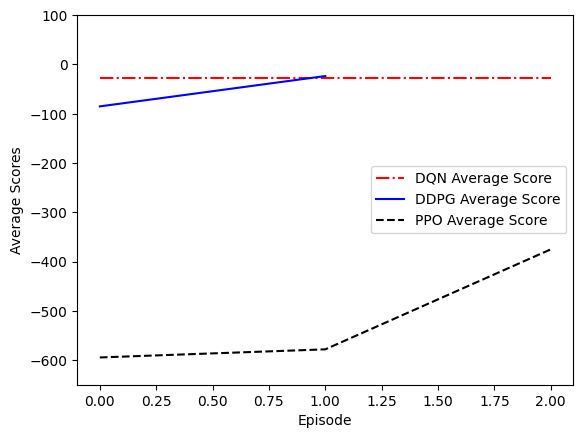

In [19]:
DDPG_ac = pd.Series(DDPG_ac, name='DDPG_ac')
DDPG_scores = pd.Series(DDPG_scores, name='DDPG_scores')
DDPG_average_score=pd.Series(DDPG_avg,name='DDPG_avg')

PPO_ac = pd.Series(PPO_ac, name='PPO_ac')
PPO_scores = pd.Series(PPO_scores, name='PPO_scores')
PPO_average_score=pd.Series(PPO_avg,name='PPO_avg')

DQN_ac = pd.Series(DQN_ac, name='DQN_ac')
DQN_scores = pd.Series(DQN_scores, name='DQN_scores')
DQN_average_score=pd.Series(DQN_avg,name='DQN_avg')


df = pd.concat([DQN_ac,DQN_scores, DQN_average_score, DDPG_ac,DDPG_scores,DDPG_average_score,PPO_ac,PPO_scores,PPO_average_score],axis=1)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(df['DQN_avg'], 'r-.',label='DQN Average Score')
plt.plot(df['DDPG_avg'],'b',label='DDPG Average Score')
plt.plot(df['PPO_avg'],'k--' ,label='PPO Average Score')
plt.ylim([-650, 100])
# plt.plot(df['Averagescores'])
plt.ylabel('Average Scores')
plt.xlabel('Episode')
plt.legend()
# plt.xlabel(f'Episode {len(df['DQN_avg'])}')

plt.savefig((p_model/'Test_average2.png'))
plt.show()
df.to_csv((p_model/'scores.csv'))

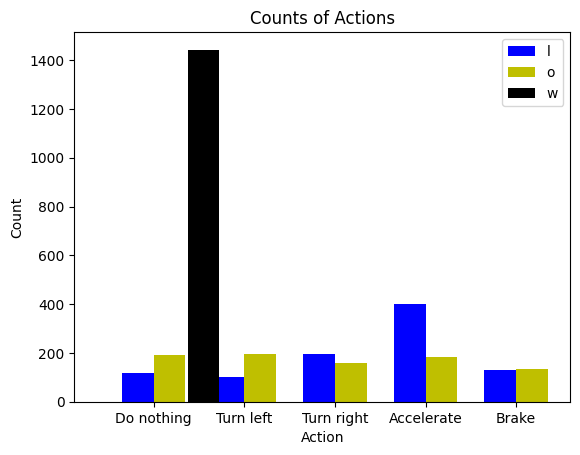

In [20]:
action_list = [0,1,2,3,4]
action_item = ('Do nothing', 'Turn left', 'Turn right','Accelerate','Brake')
h1= []
h2 =[]
h3 =[]

for i in action_list:
    h1.append(df[df['PPO_ac']==i]['PPO_ac'].count())
    h2.append(df[df['DDPG_ac']==i]['DDPG_ac'].count())
    h3.append(df[df['DQN_ac']==i]['DQN_ac'].count())
x_labels = np.array(action_list)
bar_width = 0.35

fig, ax = plt.subplots()

ax.bar(x_labels - bar_width/2, h1, bar_width, label='PPO agent',color='b')
ax.bar(x_labels + bar_width/2, h2, bar_width, label='DDPG agent',color='y')
ax.bar(x_labels - bar_width-0.2/2, h3, bar_width, label='DQN agent',color='k')

ax.set_xlabel('Action')
ax.set_ylabel('Count')
ax.set_title('Counts of Actions')
plt.legend('lower center')
plt.xticks(x_labels,action_item)

# plt.savefig((p_model/'Test_action_counts2.png'))

plt.show()
